# Deep Q-Learning para _football_ 

Autor: *Luciano Gandini*

This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

Aplicación del algoritmo DQN visto en la ECI 2019 para el entorno [_Football_](https://github.com/google-research/football) escenario `academy_run_to_score`. 

Ejecución local: requiere instalación según [instrucciones](https://github.com/jgromero/eci2019-DRL/blob/master/ejercicio/Instrucciones%20Entorno%20Football.pdf), no se precisa ninguna otra librería fuera de las mencionadas en el instructivo incluyendo el paso 7.

<a href="http://www.youtube.com/watch?feature=player_embedded&v=F8DcgFDT9sc" target="_blank"><img src="http://img.youtube.com/vi/F8DcgFDT9sc/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="580" border="3" /></a> 

## Iniciar entorno virtual

En primer lugar, vamos a crear el ambiente football y el agente, este último tiene tres capas ocultas.

El ambiente no renderizará el juego gráficamente para el entrenamiento, esto lo podremos ver ejecutando las siguientes notebooks.

In [ ]:
import gfootball.env as football_env
from dqn_agent_simultaneous_update import Agent
from gfootball.env import football_action_set

env = football_env.create_environment(
    env_name='academy_run_to_score', 
    stacked=False,                           # solo estado, no pixeles 
    representation='simple115',              # solo estado, no pixeles 
    rewards='scoring,checkpoints',           # con recompensas intermedias.
    render=False)                            # mostrar graficamente

agent = Agent(state_size=115, action_size=21, seed=0)

## Logging
Deshabilitaremos el logging a nivel WARNING para reducer la verbosidad del entorno _football_.

In [2]:
import logging, os
logging.disable(logging.WARNING)

## Algoritmo

Como se informo previamente utilizaremos DQN para el agente con actualización simultanea, no se realizaron modificaciones a la implementación vista en clase.

Se optó por variar la recompensa del ambiente multiplicandolo por diez y elevando el resultado al cubo, esto permite que al usar checkpoints los goles sean más valiosos y mantener una recompensa negativo al obtener un gol en contra.

In [3]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Episodio 50	Puntuacion media (50 anteriores): 0.08
Episodio 100	Puntuacion media (50 anteriores): 0.19
Episodio 150	Puntuacion media (50 anteriores): 0.11
Episodio 200	Puntuacion media (50 anteriores): 0.02
Episodio 250	Puntuacion media (50 anteriores): -0.03
Episodio 300	Puntuacion media (50 anteriores): 0.13
Episodio 350	Puntuacion media (50 anteriores): 0.38
Episodio 400	Puntuacion media (50 anteriores): 0.43
Episodio 450	Puntuacion media (50 anteriores): 0.30
Episodio 500	Puntuacion media (50 anteriores): 0.27
Episodio 550	Puntuacion media (50 anteriores): 0.42
Episodio 600	Puntuacion media (50 anteriores): 0.41
Episodio 650	Puntuacion media (50 anteriores): 0.41
Episodio 700	Puntuacion media (50 anteriores): 0.40
Episodio 750	Puntuacion media (50 anteriores): 0.25
Episodio 800	Puntuacion media (50 anteriores): 0.26
Episodio 850	Puntuacion media (50 anteriores): 0.29
Episodio 900	Puntuacion media (50 anteriores): 0.24
Episodio 950	Puntuacion media (50 anteriores): 0.31
Episodio 100

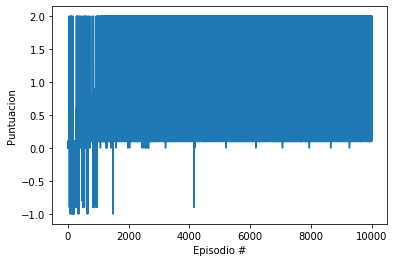

In [4]:
def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): numero maximo de episodios de entrenamiento (n_episodios)
        max_t (int): numero maximo de pasos por episodio (n_entrenamiento)
        eps_start (float): valor inicial de epsilon
        eps_end (float): valor final de epsilon
        eps_decay (float): factor de multiplicacion (por episodio) de epsilon
    """
    scores = []                        # puntuaciones de cada episodio
    scores_window = deque(maxlen=50)  # puntuaciones de los ultimos 100 episodios
    eps = eps_start                    # inicializar epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            
            # elegir accion At con politica e-greedy
            action = agent.act(state, eps)
            
            # aplicar At y obtener Rt+1, St+1
            next_state, reward, done, _ = env.step(action)
            
            # almacenar <St, At, Rt+1, St+1>
            agent.memory.add(state, action, (reward * 10) ** 3, next_state, done)
            
            # train & update
            agent.step(state, action, reward, next_state, done)
            
            # avanzar estado
            state = next_state
            score += reward
            
            if done:
                break 

        scores_window.append(score)       # guardar ultima puntuacion
        scores.append(score)              # guardar ultima puntuacion
        eps = max(eps_end, eps_decay*eps) # reducir epsilon
        
        #print('\rEpisodio {}\tPuntuacion media (ultimos {:d}): {:.2f}'.format(i_episode, 50, np.mean(scores_window)), end="")
        if i_episode % 50 == 0:
            print('\rEpisodio {}\tPuntuacion media ({:d} anteriores): {:.2f}'.format(i_episode, 50, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') # guardar pesos de agente entrenado
        if np.mean(scores_window)>=2.0:
            print('\nProblema resuelto en {:d} episodios!\tPuntuacion media (ultimos {:d}): {:.2f}'.format(i_episode-50, 50, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') # guardar pesos de agente entrenado
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion')
plt.xlabel('Episodio #')
plt.show()

## Resultado

En este caso el algoritmo no logra obtener una puntuacion optima y al finalizar las iteraciones obtendremos la siguiente salida:

_Episodio 10000	Puntuacion media (50 anteriores): 1.77_

Sin embargo si se corre manualmente *03. DQN_runonly_final* como se indica a continuación se ve que el agente aprendió a realizar los goles correctamente.

## Reproducir el experimento

Se puede ejecutar la notebook corriendo todas las etapas, si se dese observar el avance del entrenamiento durante la ejecución se recomienda ejecutar la notebook *02. DQN_runonly* que utilizara el checkpoint de salida de este algoritmo.

Se ha incluido también un checkpoint del resultado obtenido en el experimento con el resultado anterior, para ver al agente entrenado con ese modelo ejecutar la notebook *03. DQN_runonly_final*.